In [15]:
import os
from torch.utils.data import DataLoader
from dataloader_asc import create_dataset_12_asc
import matplotlib.pyplot as plt
from PIL import ImageOps
import torchvision
import numpy as np
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import *


device = torch.device('cpu')
print(device)
path = os.getcwd()
path = '/root/notebooks/sample/dataset/ECG100_224_new/'
train_dataloader,test_dataloader,label_lead, labels=create_dataset_12_asc(path,1,None)



cpu
Classification lab : {'Lateral': 0, 'Posterior': 1, 'Anterior': 2, 'Inferior': 3, 'Normal': 4}
Number of datas 368
イメージ形
torch.Size([12, 368, 3, 112, 224])
368
368


In [16]:
for batch in train_dataloader:
    print(len(batch))
    break



5


In [17]:
# モデルクラス
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # 畳み込み層や全結合層などを定義する
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.faltten = nn.Flatten()
        self.fc1 = nn.Linear(32,32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.gap(x)
        x = self.faltten(x)
        #x = x.view(-1, 16 * 56 * 112)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# モデルのインスタンスを作成
model = CNNModel().to(device)


事前学習

In [19]:
# モデル訓練　事前学習12クラス分類

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters(), lr=0.0005)
bestscore = 1000.0
loss_list,loss_list_test = [], []
f1s, f1s_test = [],[]
acc, acc_test = [], []

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss, running_loss_test = 0.0, 0.0
    preds, label =[], []
    preds_test,label_test = [], []

    for ecg_image,labels,label_lead,patients,num_leads in train_dataloader:

        print(ecg_image.shape)
        image =ecg_image.reshape(-1,3,112,224).to(device)
        print(image.shape)
        label_lead = label_lead.reshape(-1).to(device)
        optimizer.zero_grad()  # 勾配を初期化
        
        outputs = model(image)  # モデルの出力を計算

        prob, pred=torch.max(outputs,1)
        preds.extend(pred.tolist())
        label.extend(label_lead.tolist())
        loss = criterion(outputs, label_lead)  # 損失を計算
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss += loss.item()


    for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)

        label_lead = label_lead.reshape(-1).to(device)

        outputs = model(image)  # モデルの出力を計算
        
        prob, pred=torch.max(outputs,1)
        preds_test.extend(pred.tolist())
        label_test.extend(label_lead.tolist())
        
        loss = criterion(outputs, label_lead)  # 損失を計算

        running_loss_test += loss.item()
    
    score = running_loss_test/len(test_dataloader)
    
    loss_list.append(running_loss/len(train_dataloader))
    loss_list_test.append(running_loss_test/len(test_dataloader))
    f1 = f1_score(preds,label,average='macro')
    f1_test = f1_score(preds_test,label_test,average='macro')
    f1s.append(f1)
    f1s_test.append(f1_test)
    accuracy = accuracy_score(preds,label)
    accuracy_test = accuracy_score(preds_test,label_test)
    acc.append(accuracy)
    acc_test.append(accuracy_test)


    if score < bestscore:
        bestscore = score
        torch.save(model.state_dict(), '/root/notebooks/sample/models/bestmodel_asc.pth')
        print('best score!!')
        bestf1 = f1_test
        bestacc= accuracy_test

    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs}] Train-Loss: {running_loss/len(train_dataloader)} Test-Loss: {running_loss_test/len(train_dataloader)} Train-f1: {f1} Test-f1: {f1_test} Train-acc: {accuracy} Test-acc: {accuracy_test}")

torch.Size([180, 12, 3, 112, 224])
torch.Size([2160, 3, 112, 224])
torch.Size([114, 12, 3, 112, 224])
torch.Size([1368, 3, 112, 224])
best score!!
Epoch [1/2] Train-Loss: 2.493733763694763 Test-Loss: 1.2466477155685425 Train-f1: 0.012820512820512822 Test-f1: 0.012820512820512822 Train-acc: 0.08333333333333333 Test-acc: 0.08333333333333333
torch.Size([180, 12, 3, 112, 224])
torch.Size([2160, 3, 112, 224])
torch.Size([114, 12, 3, 112, 224])
torch.Size([1368, 3, 112, 224])
best score!!
Epoch [2/2] Train-Loss: 2.493154525756836 Test-Loss: 1.2463710308074951 Train-f1: 0.012820512820512822 Test-f1: 0.012820512820512822 Train-acc: 0.08333333333333333 Test-acc: 0.08333333333333333


In [ ]:
print(bestf1)
print(bestacc)

0.11624414441312125
0.1677927927927928


In [ ]:
# モデル評価
pred,label = [],[]
model.load_state_dict(torch.load('/root/notebooks/sample/models/bestmodel_asc.pth'))
model.eval()

for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
    image =ecg_image.reshape(-1,3,112,224).to(device)
    label_lead = label_lead.reshape(-1).to(device)
    label.extend(label_lead.tolist())
    outputs = model(image)  # モデルの出力を計算
    prob, preds=torch.max(outputs,1)
    pred.extend(preds.tolist())
    f1_test = f1_score(preds.tolist(),label_lead.tolist(),average='macro')
    
    loss = criterion(outputs, label_lead)  # 損失を計算

    running_loss_test += loss.item()

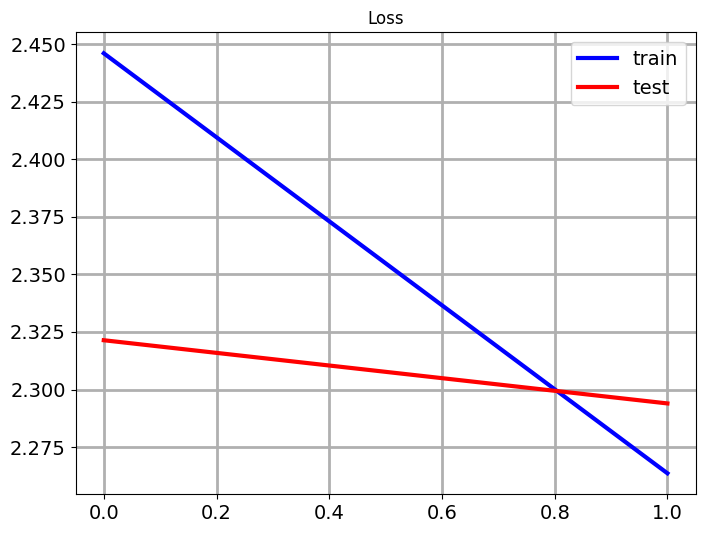

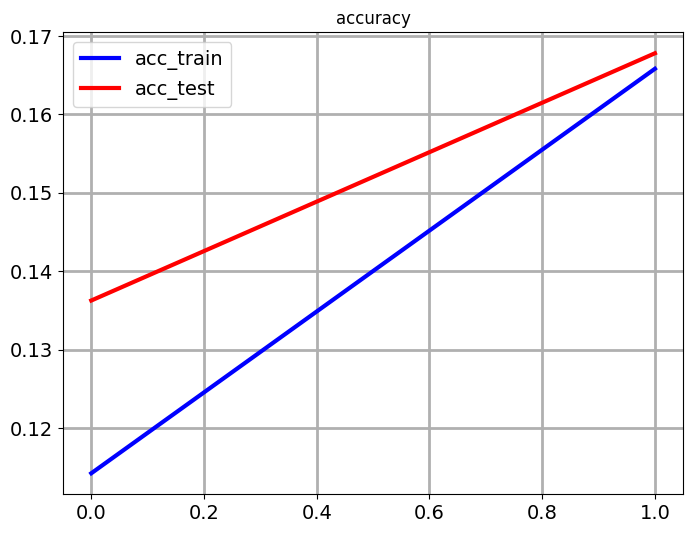

In [ ]:
# 学習曲線 (損失関数) 事前学習
plt.figure(figsize=(8,6))
plt.plot(loss_list,label='train', lw=3, c='b')
plt.plot(loss_list_test,label='test', lw=3, c='r')
plt.title('Loss')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (accuracy)
plt.figure(figsize=(8,6))
plt.plot(acc,label='acc_train', lw=3, c='b')
plt.plot(acc_test,label='acc_test', lw=3, c='r')
plt.title('accuracy')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()


Confusion matrix, without normalization
[[ 1 14  0 15 32  3  0  0  3  0  5  1]
 [ 0 24  0 11 11  4  0  0  8  0 12  4]
 [ 0 16  0 19 25  4  0  2  5  0  3  0]
 [ 0  9  0 28 26  7  0  0  0  0  2  2]
 [ 0  6  0 12 47  2  0  1  3  0  2  1]
 [ 0 23  0 17 23  4  0  2  4  0  1  0]
 [ 0 18  0 14 18  5  0  0 10  0  8  1]
 [ 0 16  0  5  2  2  0 12 25  0 11  1]
 [ 0 12  0  8  2  1  0 15 23  0 12  1]
 [ 0  9  0  6  3  4  0 11 31  0  8  2]
 [ 0 15  0 11  7  3  0  1 23  0 10  4]
 [ 0 29  0 17  6  5  0  0 10  0  7  0]]


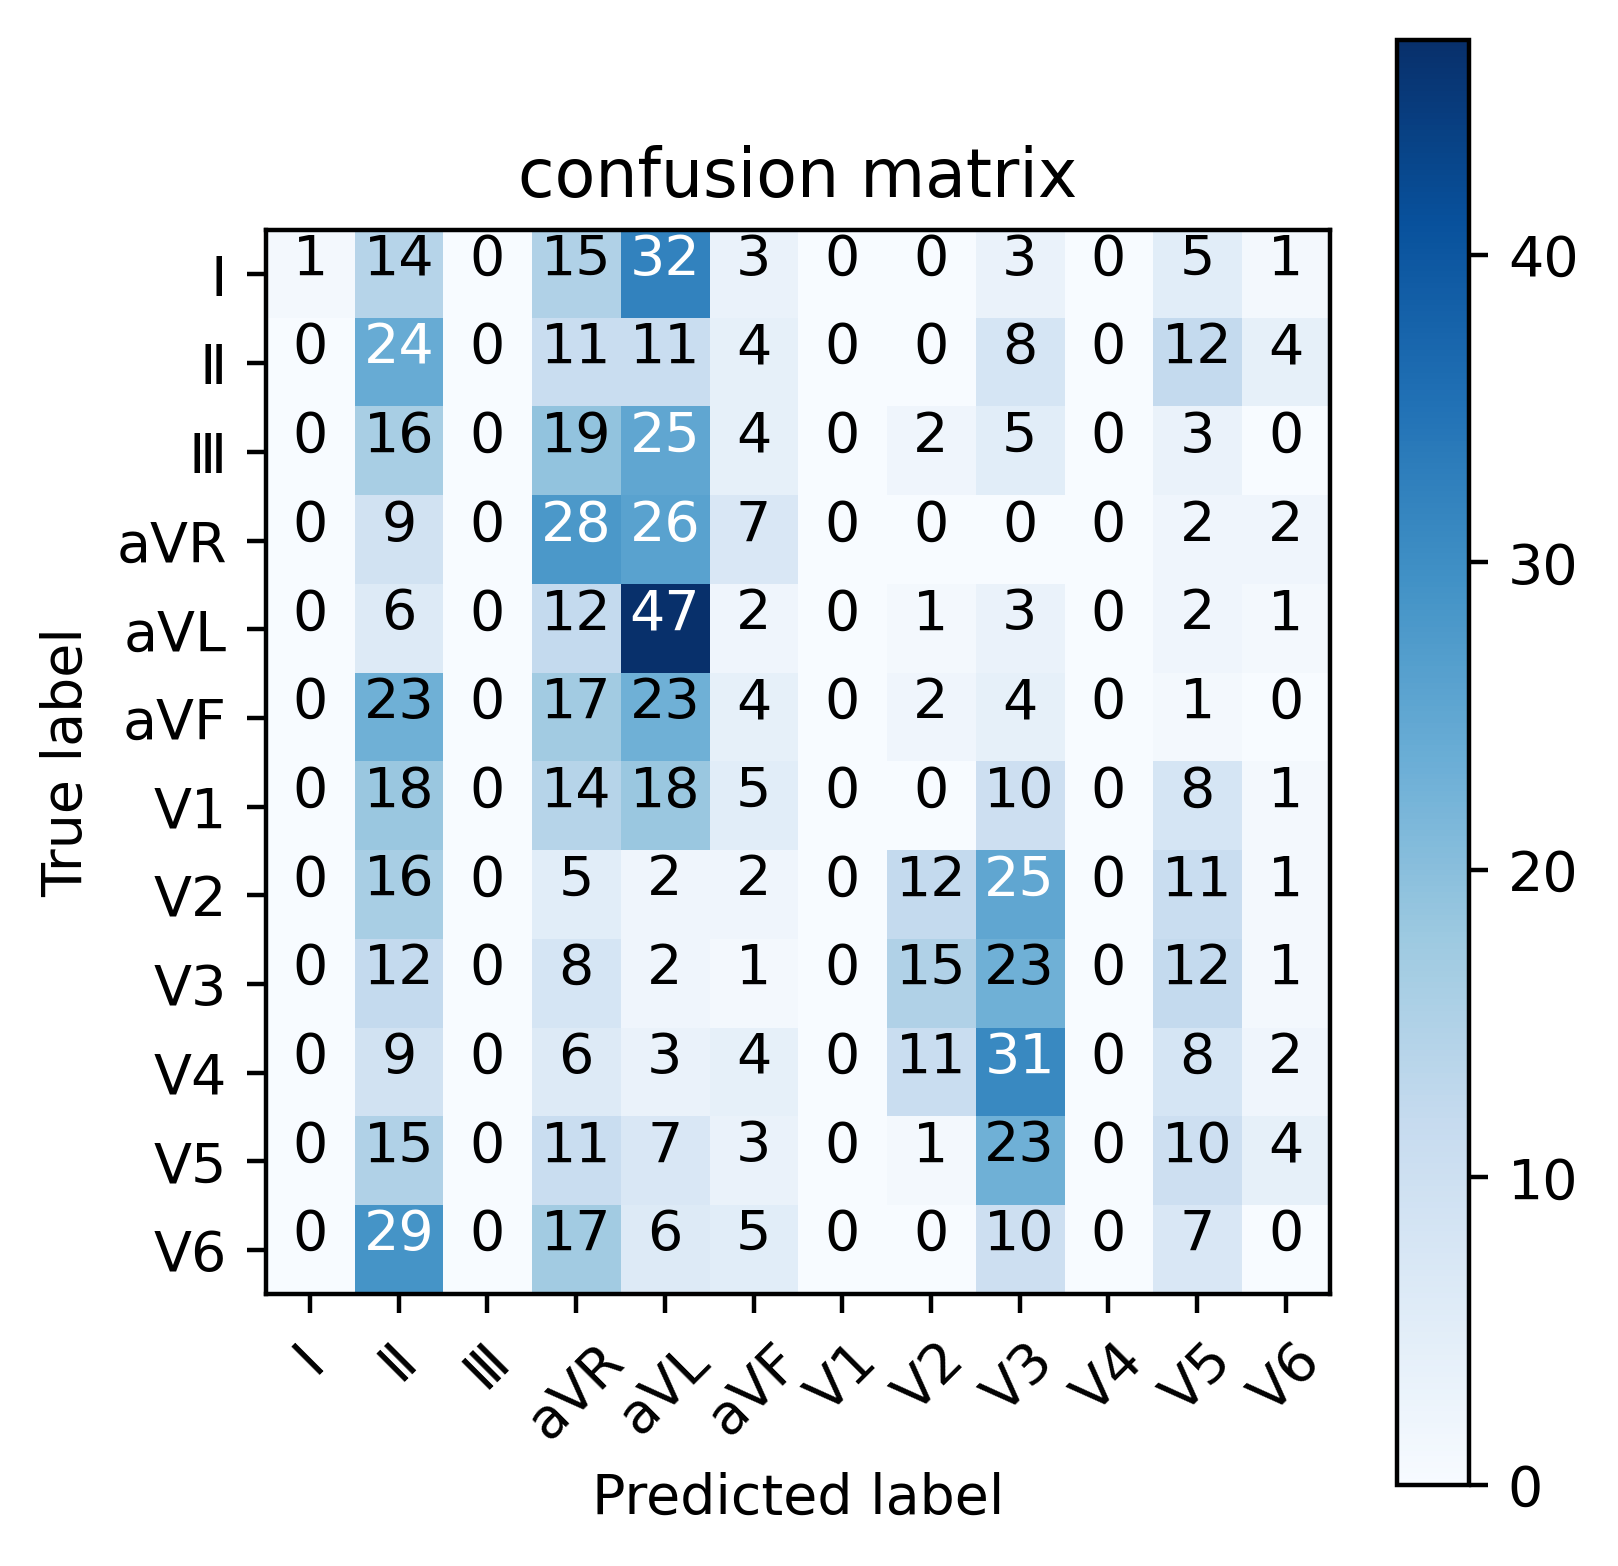

In [ ]:
# Confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
           """
           This function prints and plots the confusion matrix.
           Normalization can be applied by setting `normalize=True`.
           """
           if normalize:
               cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
               print("Normalized confusion matrix")
           else:
               print('Confusion matrix, without normalization')
           print(cm)
           plt.imshow(cm, interpolation='nearest', cmap=cmap)
           plt.title(title)
           plt.colorbar()
           tick_marks = np.arange(len(classes))
           plt.xticks(tick_marks, classes, rotation=45)
           plt.yticks(tick_marks, classes)
           fmt = '.2f' if normalize else 'd'
           thresh = cm.max() / 2.
           for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
               plt.text(j, i, format(cm[i, j], fmt),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
           plt.tight_layout()
           plt.ylabel('True label')
           plt.xlabel('Predicted label')
           #plt.savefig(output_file)


labels=[0,1,2,3,4,5,6,7,8,9,10,11]
label2=['Ⅰ','Ⅱ','Ⅲ','aVR','aVL','aVF','V1', 'V2', 'V3', 'V4', 'V5','V6']
cnf_matrix=confusion_matrix(label,pred,labels=labels)
title="confusion matrix"
plt.figure(figsize=(4,4),dpi=400)
plot_confusion_matrix(cnf_matrix, classes=label2,title=title)
plt.show()

ファインチューニング

In [22]:
# attention

class Attention_Input(nn.Module):
    def __init__(self):
        super(Attention_Input, self).__init__()
        self.cls_token = nn.Parameter(torch.randn(32))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x と cls_token を連結
        z_0 = torch.cat([self.cls_token.unsqueeze(0), x], dim=0)
        return z_0
# AttentionInputをnn.Moduleに変更
class AttentionInput(nn.Module):
    def __init__(self):
        super(AttentionInput, self).__init__()
        self.attention_input = Attention_Input()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # AttentionInputのforwardメソッドを呼び出す
        output = self.attention_input(x)
        return output

class AttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(AttentionLayer, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        # MultiheadAttentionのためにクエリ、キー、バリューの変換を行う層を定義
        self.query_transform = nn.Linear(embed_dim, embed_dim)
        self.key_transform = nn.Linear(embed_dim, embed_dim)
        self.value_transform = nn.Linear(embed_dim, embed_dim)

        # MultiheadAttentionレイヤー
        self.multihead_attention = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x):
        # クエリ、キー、バリューの変換
        query = self.query_transform(x)
        key = self.key_transform(x)
        value = self.value_transform(x)

        # MultiheadAttentionの適用
        attention_output, _ = self.multihead_attention(query, key, value)
        return attention_output

# # Attentionの出力からCLSトークンを取り出す    
class Take_cls(nn.Module):
    def forward(self, x):
        return x[0, :].reshape(1, 32)

In [23]:
# CNNモデルの特徴抽出器を取り出す
feature_extractor = nn.Sequential(*list(model.children())[:-3])

att_input = AttentionInput().to(device)
att_layer = AttentionLayer(32, 4).to(device)
take_cls = Take_cls().to(device)


CNN_diagnosis = nn.Sequential(
    feature_extractor,
    att_input,
    att_layer,
    att_layer,
    take_cls,
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 5)
)


CNN_diagnosis.to(device)

print(CNN_diagnosis)

input_shape = (12, 3, 112, 224)

# ランダムなテンソルを生成
random_input = torch.randn(input_shape).to(device)

#モデルにランダムなテンソルを渡して出力を得る
random_output = CNN_diagnosis(random_input).to(torch.float64)
feature_output = feature_extractor(random_input).to(torch.float64)
print(random_output.shape)
print(feature_output.shape)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): AdaptiveAvgPool2d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (1): AttentionInput(
    (attention_input): Attention_Input()
  )
  (2): AttentionLayer(
    (query_transform): Linear(in_features=32, out_features=32, bias=True)
    (key_transform): Linear(in_features=32, out_features=32, bias=True)
    (value_transform): Linear(in_features=32, out_features=32, bias=True)
    (multihead_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
  )
  (3): AttentionLayer(
    (query_transform): Linear(in_features=32, out_features=32, bias=True)
    (key_transfo

In [24]:
## 診断モデル

# 損失関数
criterion = nn.CrossEntropyLoss()


# 最適化アルゴリズム
optimizer = optim.Adam(CNN_diagnosis.parameters(), lr=0.0001)
bestscore_dx = 1000.0
loss_list_dx,loss_list_test_dx = [], []
f1s_dx, f1s_test_dx = [],[]
acc_dx, acc_test_dx = [], []

num_epochs_dx = 2

# モデル訓練　5クラス分類

for epoch in range(num_epochs_dx):
    CNN_diagnosis.train()
    running_loss_dx = 0.0
    preds_dx, label_dx = [], []
    running_loss_dx, running_loss_test_dx = 0.0, 0.0
    preds_test_dx,label_test_dx = [], []

    for ecg_image, labels, label_lead, patients, num_leads in train_dataloader:
        image = ecg_image.reshape(-1, 3, 112, 224).to(device)
        labels = labels.reshape(-1).to(device)  # ラベルを1次元に変形
        labels = labels.to(torch.long)  # CrossEntropyLossではクラスのインデックスはlong型である必要がある

        optimizer.zero_grad()  # 勾配を初期化

        outputs = CNN_diagnosis(image).to(torch.float64)  # モデルの出力を計算

        prob, pred = torch.max(outputs, 1)
        preds_dx.extend(pred.tolist())
        label_dx.extend(labels.tolist())

        loss = criterion(outputs, labels)  # 損失を計算（CrossEntropyLossの引数は予測とラベル）
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss_dx += loss.item()

    for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        labels = labels.reshape(-1).to(device)

        outputs = CNN_diagnosis(image)  # モデルの出力を計算
        outputs = outputs.to(torch.float64)
        prob, pred=torch.max(outputs,1)
        preds_test_dx.extend(pred.tolist())
        label_test_dx.extend(labels.tolist())
        
        #print(outputs)
        loss = criterion(outputs, labels)  # 損失を計算

        running_loss_test_dx += loss.item()
    
    score_dx = running_loss_test_dx/len(test_dataloader)
    
    loss_list_dx.append(running_loss_dx/len(train_dataloader))
    loss_list_test_dx.append(running_loss_test_dx/len(test_dataloader))
    f1_dx = f1_score(preds_dx,label_dx,average='macro')
    f1_test_dx = f1_score(preds_test_dx,label_test_dx,average='macro')
    f1s_dx.append(f1_dx)
    f1s_test_dx.append(f1_test_dx)
    accuracy_dx = accuracy_score(preds_dx,label_dx)
    accuracy_test_dx = accuracy_score(preds_test_dx,label_test_dx)
    acc_dx.append(accuracy_dx)
    acc_test_dx.append(accuracy_test_dx)

    if score_dx < bestscore_dx:
        bestscore_dx = score_dx
        torch.save(CNN_diagnosis.state_dict(), '/root/notebooks/sample/models/bestmodel_dx_asc.pth')
        print('best score_dx!!')
        bestf1_dx = f1_test_dx
        bestacc_dx = accuracy_test_dx

    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs_dx}] Train-Loss: {running_loss_dx/len(train_dataloader)} Test-Loss: {running_loss_test_dx/len(train_dataloader)} Train-f1: {f1_dx} Test-f1: {f1_test_dx} Train-acc: {accuracy_dx} Test-acc: {accuracy_test_dx}")

ValueError: Expected input batch_size (1) to match target batch_size (180).

In [ ]:
print(bestf1_dx)
print(bestacc_dx)

0.12592592592592594
0.4594594594594595


In [ ]:
# モデル評価 ５クラス診断
pred_dx,label_dx = [],[]
CNN_diagnosis.load_state_dict(torch.load('/root/notebooks/sample/models/bestmodel_dx_asc.pth'))
CNN_diagnosis.eval()

for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
    image =ecg_image.reshape(-1,3,112,224).to(device)
    labels = labels.reshape(-1).to(device)
    label_dx.extend(labels.tolist())
    outputs = CNN_diagnosis(image)  # モデルの出力を計算
    prob_dx, preds_dx=torch.max(outputs,1)
    pred_dx.extend(preds_dx.tolist())
    f1_test_dx = f1_score(preds_dx.tolist(),labels.tolist(),average='macro')
    accuracy_test_dx = accuracy_score(preds_test_dx,label_test_dx)
    loss = criterion(outputs, labels)  # 損失を計算

    running_loss_test_dx += loss.item()


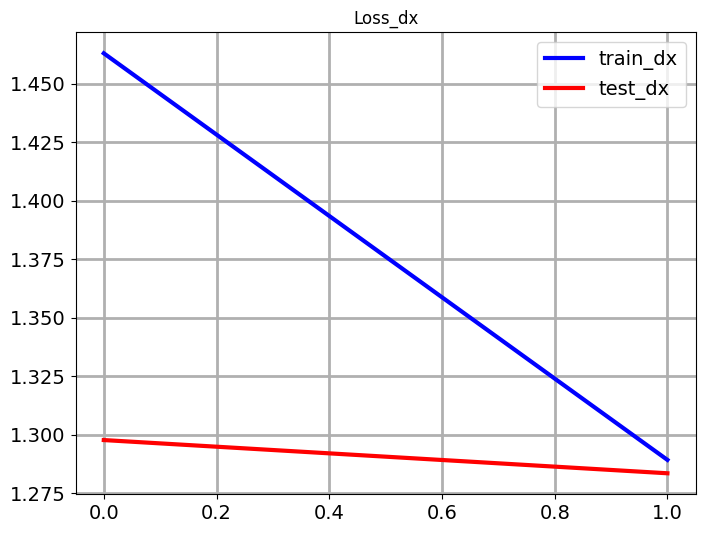

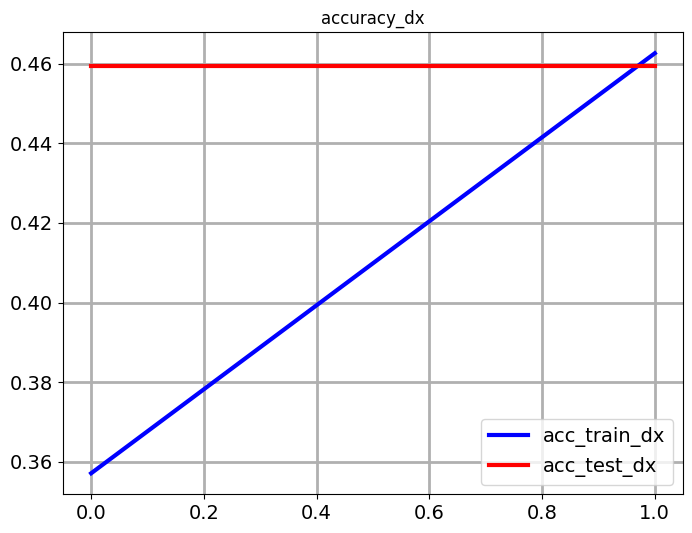

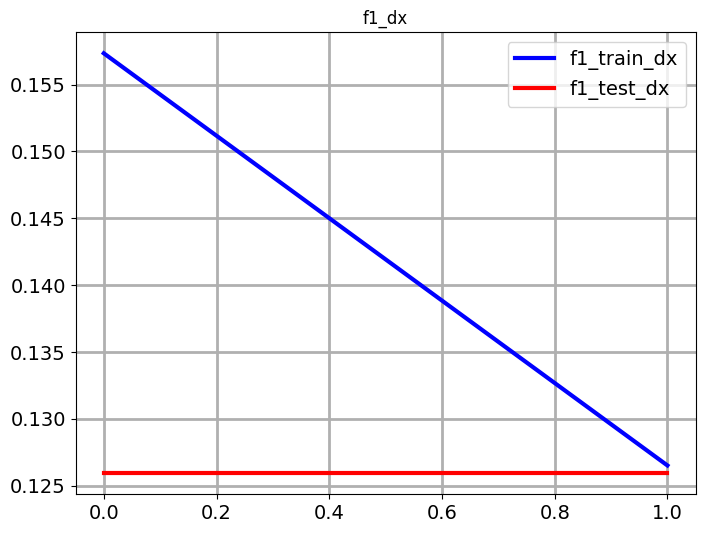

In [ ]:
# 学習曲線 (損失関数) 診断モデル
plt.figure(figsize=(8,6))
plt.plot(loss_list_dx,label='train_dx', lw=3, c='b')
plt.plot(loss_list_test_dx,label='test_dx', lw=3, c='r')
plt.title('Loss_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (accuracy)
plt.figure(figsize=(8,6))
plt.plot(acc_dx,label='acc_train_dx', lw=3, c='b')
plt.plot(acc_test_dx,label='acc_test_dx', lw=3, c='r')
plt.title('accuracy_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (f1)
plt.figure(figsize=(8,6))
plt.plot(f1s_dx,label='f1_train_dx', lw=3, c='b')
plt.plot(f1s_test_dx,label='f1_test_dx', lw=3, c='r')
plt.title('f1_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

Confusion matrix, without normalization
[[ 0  0  0  0  1]
 [ 0  0  0  0  5]
 [ 0  0  0  0 18]
 [ 0  0  0  0 16]
 [ 0  0  0  0 34]]


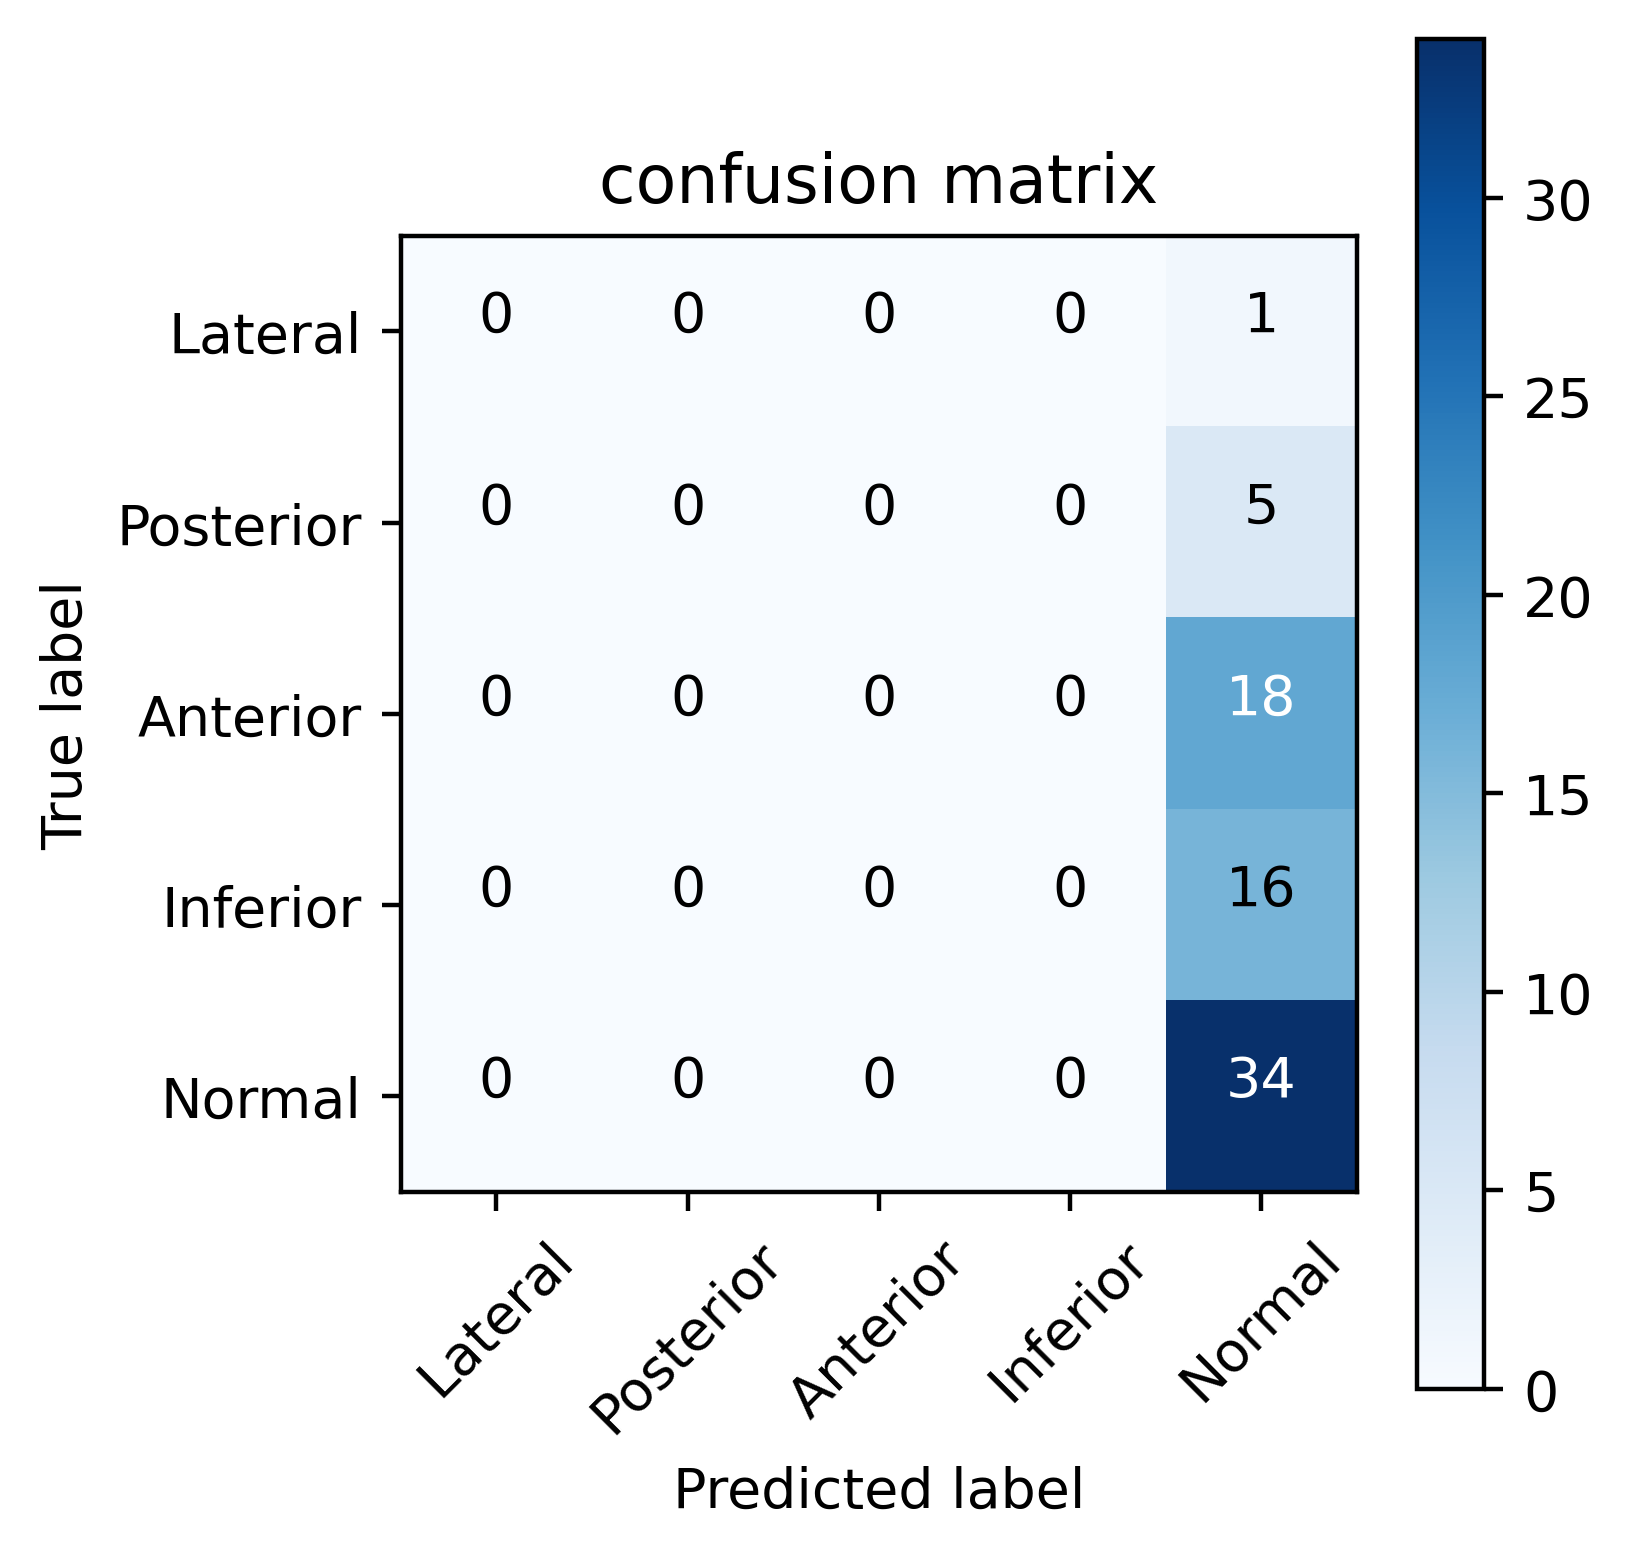

In [ ]:
labels_dx=[0,1,2,3,4]
label2_dx=['Lateral','Posterior', 'Anterior', 'Inferior', 'Normal']
cnf_matrix=confusion_matrix(label_dx,pred_dx,labels=labels_dx)
title="confusion matrix"
plt.figure(figsize=(4,4),dpi=400)
plot_confusion_matrix(cnf_matrix, classes=label2_dx,title=title)
plt.show()

In [ ]:
# モデルのインスタンスを作成
model_np = CNNModel().to(device)
model_np = nn.Sequential(*list(model_np.children())[:-3])

model_np = nn.Sequential(
    model_np,
    att_input,
    att_layer,
    att_layer,
    take_cls,
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 5)
)

model_np.to(device)




Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): AdaptiveAvgPool2d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (1): AttentionInput(
    (attention_input): Attention_Input()
  )
  (2): AttentionLayer(
    (query_transform): Linear(in_features=32, out_features=32, bias=True)
    (key_transform): Linear(in_features=32, out_features=32, bias=True)
    (value_transform): Linear(in_features=32, out_features=32, bias=True)
    (multihead_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
  )
  (3): AttentionLayer(
    (query_transform): Linear(in_features=32, out_features=32, bias=True)
    (key_transfo

In [ ]:
# 診断 (事前学習なし)

# 損失関数
criterion = nn.CrossEntropyLoss()


# 最適化アルゴリズム
optimizer = optim.Adam(model_np.parameters(), lr=0.0001)
bestscore_np = 1000.0
loss_list_np,loss_list_test_np = [], []
f1s_np, f1s_test_np = [],[]
acc_np, acc_test_np = [], []

num_epochs_np = 2

# モデル訓練　5クラス分類

for epoch in range(num_epochs_np):
    model_np.train()
    running_loss_np = 0.0
    preds_np, label_np = [], []
    running_loss_np, running_loss_test_np = 0.0, 0.0
    preds_test_np,label_test_np = [], []

    for ecg_image, labels, label_lead, patients, num_leads in train_dataloader:
        image = ecg_image.reshape(-1, 3, 112, 224).to(device)
        labels = labels.reshape(-1).to(device)  # ラベルを1次元に変形
        labels = labels.to(torch.long)  # CrossEntropyLossではクラスのインデックスはlong型である必要がある

        optimizer.zero_grad()  # 勾配を初期化

        outputs = model_np(image).to(torch.float64)  # モデルの出力を計算

        prob, pred = torch.max(outputs, 1)
        preds_np.extend(pred.tolist())
        label_np.extend(labels.tolist())

        loss = criterion(outputs, labels)  # 損失を計算（CrossEntropyLossの引数は予測とラベル）
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss_np += loss.item()

    for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        labels = labels.reshape(-1).to(device)

        outputs = model_np(image)  # モデルの出力を計算
        outputs = outputs.to(torch.float64)
        prob, pred=torch.max(outputs,1)
        preds_test_np.extend(pred.tolist())
        label_test_np.extend(labels.tolist())
        
        #print(outputs)
        loss = criterion(outputs, labels)  # 損失を計算

        running_loss_test_np += loss.item()
    
    score_np = running_loss_test_np/len(test_dataloader)

    loss_list_np.append(running_loss_np/len(train_dataloader))
    loss_list_test_np.append(running_loss_test_np/len(test_dataloader))
    f1_np = f1_score(preds_np,label_np,average='macro')
    f1_test_np = f1_score(preds_test_np,label_test_np,average='macro')
    f1s_np.append(f1_np)
    f1s_test_np.append(f1_test_np)
    accuracy_np = accuracy_score(preds_np,label_np)
    accuracy_test_np = accuracy_score(preds_test_np,label_test_np)
    acc_np.append(accuracy_np)
    acc_test_np.append(accuracy_test_np)

    if score_np < bestscore_np:
        bestscore_np = score_np
        torch.save(model_np.state_dict(), '/root/notebooks/sample/models/bestmodel_np_asc.pth')
        print('best score_np!!')
        bestf1_np = f1_test_np
        bestacc_np = accuracy_test_np
        
    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs_np}] Train-Loss: {running_loss_np/len(train_dataloader)} Test-Loss: {running_loss_test_np/len(train_dataloader)} Train-f1: {f1_np} Test-f1: {f1_test_np} Train-acc: {accuracy_np} Test-acc: {accuracy_test_np}")

best score_np!!
Epoch [1/2] Train-Loss: 1.5266591124511049 Test-Loss: 0.33111261869353065 Train-f1: 0.13333118203233404 Test-f1: 0.12592592592592594 Train-acc: 0.282312925170068 Test-acc: 0.4594594594594595
best score_np!!
Epoch [2/2] Train-Loss: 1.300169779864311 Test-Loss: 0.3220523557864514 Train-f1: 0.12651162790697673 Test-f1: 0.12592592592592594 Train-acc: 0.46258503401360546 Test-acc: 0.4594594594594595


In [ ]:
print(bestf1_np)
print(bestacc_np)

0.12592592592592594
0.4594594594594595


In [ ]:
# モデル評価 ５クラス診断(事前学習なし)
pred_np,label_np = [],[]
model_np.load_state_dict(torch.load('/root/notebooks/sample/models/bestmodel_np_asc.pth'))
model_np.eval()

for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
    image =ecg_image.reshape(-1,3,112,224).to(device)
    labels = labels.reshape(-1).to(device)
    label_np.extend(labels.tolist())
    outputs = model_np(image)  # モデルの出力を計算
    prob_np, preds_np=torch.max(outputs,1)
    pred_np.extend(preds_np.tolist())
    f1_test_np = f1_score(preds_np.tolist(),labels.tolist(),average='macro')
    accuracy_test_np = accuracy_score(preds_test_np,label_test_np)
    loss = criterion(outputs, labels)  # 損失を計算

    running_loss_test_np += loss.item()


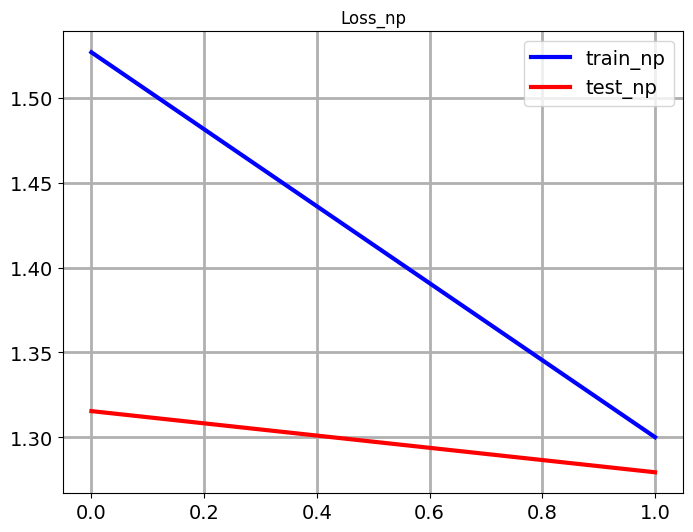

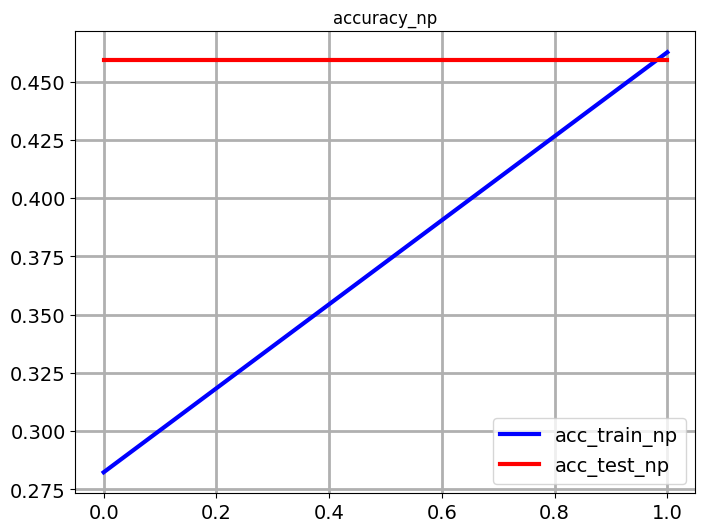

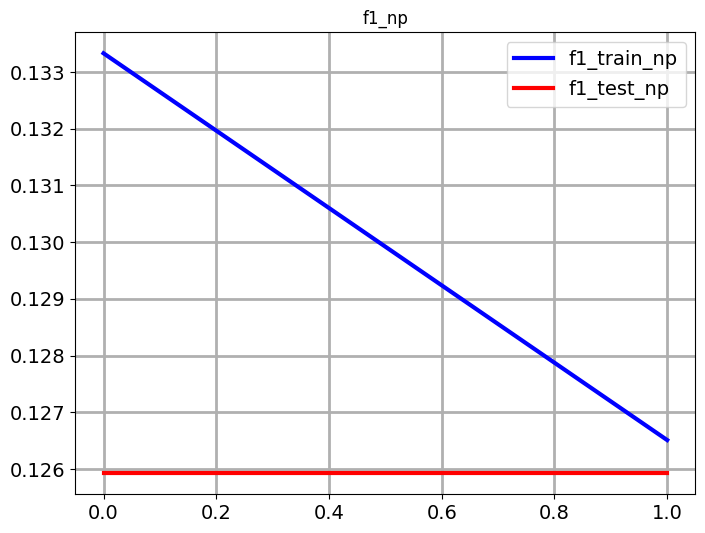

In [ ]:
# 学習曲線 (損失関数) 事前学習
plt.figure(figsize=(8,6))
plt.plot(loss_list_np,label='train_np', lw=3, c='b')
plt.plot(loss_list_test_np,label='test_np', lw=3, c='r')
plt.title('Loss_np')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (accuracy)
plt.figure(figsize=(8,6))
plt.plot(acc_np,label='acc_train_np', lw=3, c='b')
plt.plot(acc_test_np,label='acc_test_np', lw=3, c='r')
plt.title('accuracy_np')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (F1)
plt.figure(figsize=(8,6))
plt.plot(f1s_np,label='f1_train_np', lw=3, c='b')
plt.plot(f1s_test_np,label='f1_test_np', lw=3, c='r')
plt.title('f1_np')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

Confusion matrix, without normalization
[[ 0  0  0  0  1]
 [ 0  0  0  0  5]
 [ 0  0  0  0 18]
 [ 0  0  0  0 16]
 [ 0  0  0  0 34]]


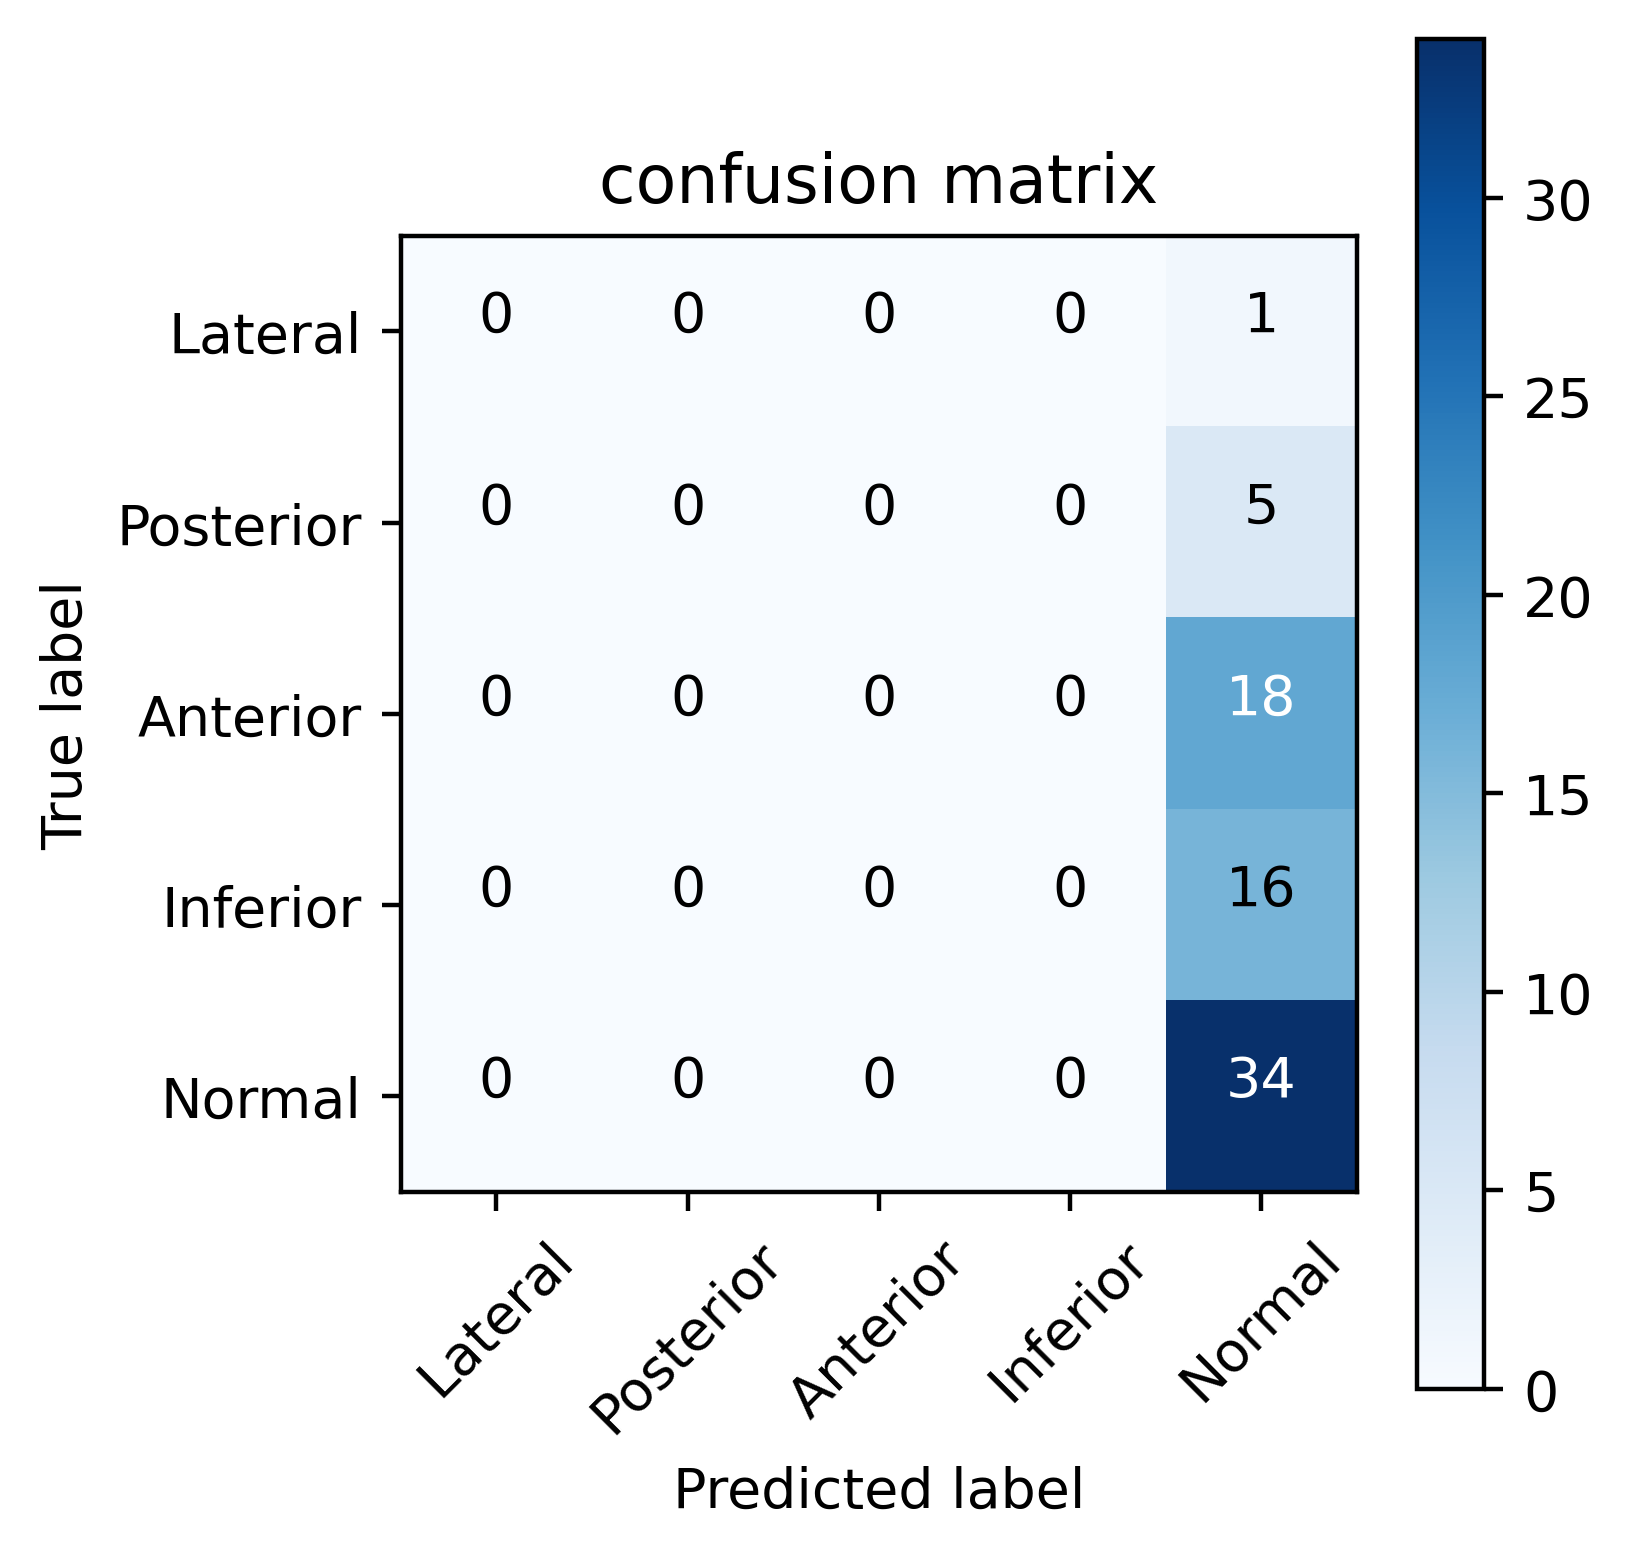

In [ ]:
labels_np=[0,1,2,3,4]
label2_np=['Lateral','Posterior', 'Anterior', 'Inferior', 'Normal']
cnf_matrix=confusion_matrix(label_np,pred_np,labels=labels_np)
title="confusion matrix"
plt.figure(figsize=(4,4),dpi=400)
plot_confusion_matrix(cnf_matrix, classes=label2_np,title=title)
plt.show()